In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, StrMethodFormatter

from scipy.optimize import curve_fit, minimize

from copy import deepcopy

# from tess_lc_rise import *

import warnings 

warnings.filterwarnings("ignore")

%matplotlib widget

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig_width_pt = 244.0  # Get this from LaTeX using \the\columnwidth
text_width_pt = 508.0 # Get this from LaTeX using \the\textwidth

# plt.rc('font', size=21)
# plt.rc('xtick', labelsize=21)
# plt.rc('ytick', labelsize=21)

inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt*1.5 # width in inches
fig_width_full = text_width_pt*inches_per_pt  # 17
fig_height =fig_width*golden_mean # height in inches
fig_size = [fig_width,fig_height] #(9,5.5) #(9, 4.5)

In [3]:
file = '/Users/zgl12/Modules/SN2019vxm/Data/tess_sector_18_aperture_calib_vxm.csv'
savepath = '/Users/zgl12/Modules/SN2019vxm/Telescopes_Scripts/TESS/Control_Curves/Detrended_Data/'

sector = file.split('_')[-4]
method = file.split('_')[-3]
calib = file.split('_')[-2]

In [4]:
def file_proc(file):
    
    df = pd.read_csv(file)

    df = df[(df['flux'] != 0)].reset_index(drop=True)
    
    zp = df['ZP'].values[0]
    zp_e = df['d_ZP'].values[0]

    diffs = np.abs(np.diff(df.MJD))
    indices = np.where(diffs > 0.5)[0]

    ind1 = 80
    ind2 = indices[0] - 30
    ind3 = indices[0]
    
    return df, zp, zp_e, ind1, ind2, ind3

def indexing_nan(df, ind1, ind2, ind3):
    mjds = deepcopy(df.MJD.values)
    fluxes = deepcopy(df.flux.values)
    d_fluxes = deepcopy(df.dflux.values)
    
    
    mjds[:ind1] = np.nan
    mjds[ind2:ind3+1] = np.nan

    fluxes[:ind1] = np.nan
    fluxes[ind2:ind3+1] = np.nan

    d_fluxes[:ind1] = np.nan
    d_fluxes[ind2:ind3+1] = np.nan
    
    return mjds, fluxes, d_fluxes

def residuals(theta, mjd, flux, flux_err):
    
    mjds = mjd[mjd >= theta[3]]
    fluxes = flux[mjd >= theta[3]]
    flux_errs = flux_err[mjd >= theta[3]]
    
    model = power_law(mjds, *theta)
    
    resid = np.nansum((abs(model - fluxes))**2 / flux_errs**2 ) / (len(fluxes) - len(theta))
    if (resid == 0) | (np.isnan(resid)):
        return np.nan
    else:
        return resid

def power_law(x, a, n, c, d): #, f):
    # d = x[0]
    # return a * (x-d)**(n*(x-d) + f) + c
    return a * (x-d)**(n) + c

def gather_data(mjds, fluxes, d_fluxes, ind3):

    guess = [2.7, 1.4, -0.8, 58804]

    res = minimize(residuals, guess, args = (mjds[ind3:], fluxes[ind3:], d_fluxes[ind3:]))
    
    mjds_res = mjds[ind3:][mjds[ind3:] >= res.x[3]]
    fluxes_res = fluxes[ind3:][mjds[ind3:] >= res.x[3]]
    flux_errs_res = d_fluxes[ind3:][mjds[ind3:] >= res.x[3]]
    
    popt, pcov = curve_fit(power_law, mjds_res, fluxes_res, p0 = res.x, sigma = flux_errs_res, absolute_sigma = True, maxfev = 1000)
    
    resid = residuals(popt, mjds[ind3:], fluxes[ind3:], d_fluxes[ind3:])
    
    return popt, pcov, resid

def weighted_value_and_uncertainty(data, uncertainties, mode = 'lc'):

    # Calculate weights as the inverse of the uncertainties squared
    weights = 1 / uncertainties**2

    # Calculate weighted mean
    if mode == 'lc':
        weighted_mean = np.nansum(weights * data) / np.nansum(weights)
        weighted_uncertainty = np.sqrt(1 / np.nansum(weights))
    elif mode == 'field':
        weighted_mean = np.nansum(weights * data, axis = 0) / np.nansum(weights, axis = 0)
        weighted_uncertainty = np.sqrt(1 / np.nansum(weights, axis = 0))

    return weighted_mean, weighted_uncertainty

def weighting(final_resids_df):
    ds= final_resids_df[abs(final_resids_df['residuals'].idxmin() - final_resids_df.index.values) < 10]['d'].values
    d_ds= final_resids_df[abs(final_resids_df['residuals'].idxmin() - final_resids_df.index.values) < 10]['d_d'].values

    d_ds = d_ds[np.isfinite(d_ds)]
    ds = ds[np.isfinite(ds)]

    opt_val, add_uncert = weighted_value_and_uncertainty(ds, d_ds, mode = 'lc')
    
    return opt_val, add_uncert, final_resids_df['residuals'].idxmin()

def running_optimise_d(mjds, fluxes, d_fluxes, ind3):

    final_resids_df = pd.DataFrame(columns = ['index', 'residuals', 'a', 'n', 'c', 'd', 'd_a', 'd_n', 'd_c', 'd_d'])

    for ind in np.arange(ind3, 650):

        try:
            popt, pcov, resid = gather_data(mjds, fluxes, d_fluxes, ind)
        except:
            continue
        
        final_resids_list = [ind, resid, *popt, *np.sqrt(np.diag(pcov))]
        
        final_resids_df.loc[len(final_resids_df)] = final_resids_list
        
    opt_val, add_uncert, min_ind = weighting(final_resids_df)
        
    return final_resids_df, opt_val, add_uncert, min_ind

def linear_model(x, a, c):
    return a * x + c

def fitting_procedure_lin(mjds, fluxes, d_fluxes, ind1, ind2):

    guess_lin = [1, 2.1e+04]

    popt_lin_1, _ = curve_fit(linear_model, mjds[ind1:ind2], fluxes[ind1:ind2], sigma = d_fluxes[ind1:ind2], 
                                    p0 = guess_lin, absolute_sigma=True)
    
    # mjds[ind1:ind2], fluxes[ind1:ind2] - linear_model(mjds[ind1:ind2], *popt_lin_1)
    # mjds[ind3+1:ind4-1], fluxes[ind3+1:ind4-1] - linear_model(mjds[ind3+1:ind4-1], *popt_lin_2)
    
    return popt_lin_1

def quadratic_model(x, a, b, c):
    return a*x**2 + b*x + c

def fitting_procedure_qua(mjds, fluxes, d_fluxes, ind1, ind2):

    guess_qua = [1, 1, 2.1e+04]

    popt_qua_1, _ = curve_fit(quadratic_model, mjds[ind1:ind2], fluxes[ind1:ind2], sigma = d_fluxes[ind1:ind2], 
                                    p0 = guess_qua, absolute_sigma=True)
    
    return popt_qua_1

In [5]:

def magnitude(flux, zp = 20.023960740994795):
    m = -2.5 * np.log10(flux) + zp
    return m

def magnitude_error(f, df, dzp):
    return np.sqrt((-2.5 / np.log(10) * df/ (f))**2 + dzp**2)

def flux_to_jansky(flux, zp = 20.44):
    c = (zp - 8.9) / -2.5
    return flux * 1e6 * 10**c

def jansky_error(mag, mag_error):
    return np.sqrt((-0.4 * np.log(10) * 10**((8.9 - mag)/2.5))**2 * mag_error**2) * 1e6

def jansky_error_flux(flux, d_flux, zp, d_zp):
    
    a = 10**((8.9-zp)/2.5)
    term1 = d_flux * a
    term2 = flux * np.log(10) * a * 0.4 * d_zp
    return np.sqrt(term1**2 + term2**2) * 1e6

def saving_df(mjds, new_flux, d_fluxes, zp, zp_e, mode = 'linear'):
    saving_df = pd.DataFrame(columns=['MJD', 'flux', 'dflux', 'uJy', 'duJy', 'm', 'dm', 'ZP', 'd_ZP', 'Method', 'Sector'])

    new_mjds = mjds[np.isfinite(mjds) & np.isfinite(new_flux)]
    new_pub_flux = new_flux[np.isfinite(mjds) & np.isfinite(new_flux)]
    d_fluxes = d_fluxes[np.isfinite(mjds) & np.isfinite(new_flux)]

    uJy = flux_to_jansky(new_pub_flux, zp)
    d_uJy = jansky_error_flux(new_pub_flux, d_fluxes, zp, zp_e)
    m = magnitude(new_pub_flux, zp)
    d_m = magnitude_error(new_pub_flux, d_fluxes, zp_e)

    saving_df['MJD'] = new_mjds
    saving_df['flux'] = new_pub_flux
    saving_df['dflux'] = d_fluxes
    saving_df['uJy'] = uJy
    saving_df['duJy'] = d_uJy
    saving_df['m'] = m
    saving_df['dm'] = d_m
    saving_df['ZP'] = zp
    saving_df['d_ZP'] = zp_e
    saving_df['Method'] = 'psf'
    saving_df['Sector'] = sector
        
    saving_df.to_csv(f'{savepath}tess_sector_{sector}_{method}_{mode}_vxm.csv', index=False)

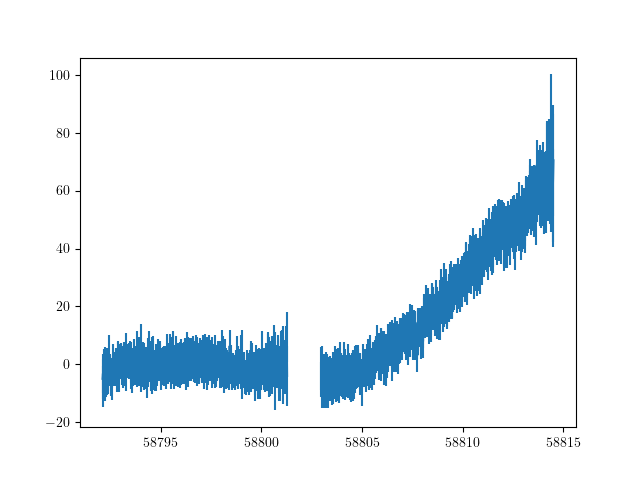

In [6]:
df, zp, zp_e, ind1, ind2, ind3 = file_proc(file)
mjds, fluxes, d_fluxes = indexing_nan(df, ind1, ind2, ind3)

d_fluxes[d_fluxes < 1] = 1

plt.figure()
plt.errorbar(mjds, fluxes, d_fluxes)
plt.show()

final_resids_df, opt_val, add_uncert, min_ind = running_optimise_d(mjds, fluxes, d_fluxes, ind3)

In [7]:
a = final_resids_df.iloc[final_resids_df['residuals'].idxmin()]['a']
n = final_resids_df.iloc[final_resids_df['residuals'].idxmin()]['n']
c = final_resids_df.iloc[final_resids_df['residuals'].idxmin()]['c']
d = final_resids_df.iloc[final_resids_df['residuals'].idxmin()]['d']

In [8]:
popt_lin_1 = fitting_procedure_lin(mjds, fluxes, d_fluxes, ind1, ind2)
popt_qua_1 = fitting_procedure_qua(mjds, fluxes, d_fluxes, ind1, ind2)

In [9]:
new_lin_flux = np.array((fluxes[:ind3] - linear_model(mjds[:ind3], *popt_lin_1)).tolist() + 
                        (fluxes[ind3:] - power_law(mjds[ind3:], a, n, c, d)).tolist())
new_qua_flux = np.array((fluxes[:ind3] - quadratic_model(mjds[:ind3], *popt_qua_1)).tolist() + 
                        (fluxes[ind3:] - power_law(mjds[ind3:], a, n, c, d)).tolist())

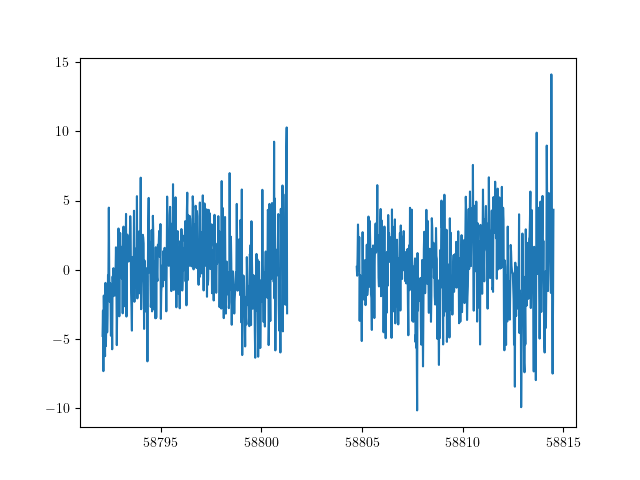

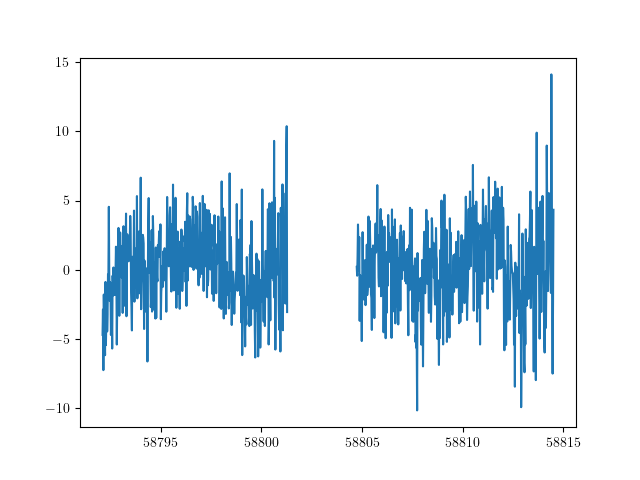

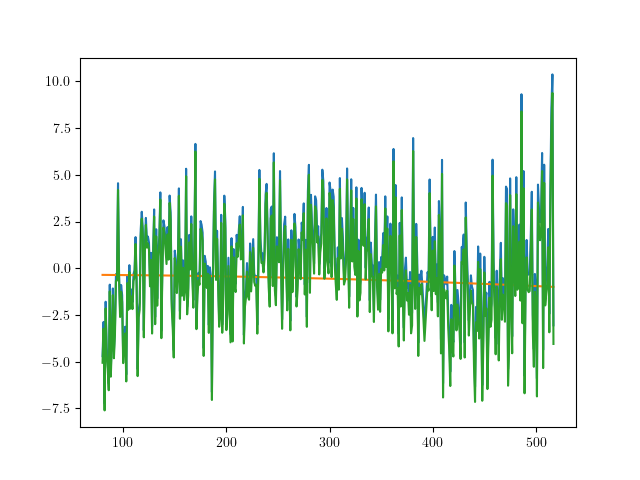

In [10]:
plt.figure()
plt.plot(mjds, new_lin_flux)
plt.show()

plt.figure()
plt.plot(mjds, new_qua_flux)
plt.show()

plt.figure()
plt.plot(fluxes[:ind3] - quadratic_model(mjds[:ind3], *popt_qua_1))
plt.plot(quadratic_model(mjds[:ind3], *popt_qua_1))
plt.plot(fluxes[:ind3])
plt.show()

In [11]:
saving_df(mjds, new_lin_flux, d_fluxes, zp, zp_e, mode = 'linear')
saving_df(mjds, new_qua_flux, d_fluxes, zp, zp_e, mode = 'quad')